## What is it about

For small values of $n$ study the statistic properties of diffusion distances of each layer of the LRX Cayley graph. For each vertex $v$ diffusion distance is defined as

$$
    \mathrm{DD}(v) = \frac{\sum\limits_{k=0}^{K_{\max}} k \mathbb P(v, k)}{\sum\limits_{k=0}^{K_{\max}}  \mathbb P(v, k)}
$$

where $\mathbb P(v, k)$ is the probability to reach $v$ from the initial state $v_0$ in $k$ steps. If $A$ is the adjacency matrix of the Cayley graph then $\mathbb P(v, k) = \frac{A^k_{0v}}{\sum\limits_j A^k_{0j}}$. 

Calculation of powers of the adjancency matrix could be infeasible even for relatively small $n$. To speed up the computations, we use dynamic programming to calculate $A^k_{0v}$ — number of paths of length $k$ from the idendity permutation $v_0$ to the state $v$.

In [1]:
!ls -l /kaggle/usr/lib/smallcg

total 400
-rw-r--r-- 1 nobody nogroup      0 Mar 24 14:09 custom.css
-rw-r--r-- 1 nobody nogroup    652 Mar 24 14:09 __output__.json
-rw-r--r-- 1 nobody nogroup 351144 Mar 24 14:09 __results__.html
-rw-r--r-- 1 nobody nogroup  16554 Mar 24 14:09 __script__.ipynb
-rw-r--r-- 1 nobody nogroup  15634 Mar 24 14:09 __script__.py
-rw-r--r-- 1 nobody nogroup  15634 Mar 24 14:09 smallcg.py


Do we have CUDA?

In [2]:
import torch
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_properties(0))
else:
    device = torch.device("cpu")
    print("no CUDA")

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16269MB, multi_processor_count=56, uuid=3226b064-cbdb-a20d-3b1c-35f3aa19f735, L2_cache_size=4MB)


In [3]:
from smallcg import TensorPerms

def LRX_moves(n):
    id_perm = list(range(n))
    L = id_perm[1:] + [id_perm[0]]
    R = [id_perm[-1]] + id_perm[:-1]
    X = id_perm
    X[0], X[1] = X[1], X[0]
    return np.array([L, R, X])

## Diffusion distances in each layer

Calculate

* average diffusion distance in each layer
* number of different values in a layer (rounded by $2$ decimal digits)
* distribution of unique values in a layer

In [4]:
from time import time

def DD_data(n, K_max_list, device=device, n_digits=2):
    LRX = TensorPerms(n, LRX_moves(n), verbose=False)
    K_max = max(K_max_list)
    num = torch.zeros(LRX.n_states,  device=device, dtype=torch.float64)
    denom = torch.zeros(LRX.n_states,  device=device, dtype=torch.float64)
    denom[0] = 1

    dd_values = []
    dd_means = []

    dp = torch.zeros(LRX.n_states, dtype=torch.float64, device=device)
    dp[1:4] = 1
    dp_new = torch.zeros(LRX.n_states, dtype=torch.float64, device=device)
    for k in range(1, K_max + 1):
        ratio = num.cpu().numpy() / denom.cpu().numpy()
        cumsums = LRX.layers_pop.cumsum()
        if k in K_max_list:
            dd_values.append([])
            dd_means.append([])
            dd_means[-1].append(ratio[0])
            dd_values[-1].append([1])
            for i in range(1, cumsums.shape[0]):
                dd_means[-1].append(ratio[cumsums[i-1]:cumsums[i]].mean())
                dd_values[-1].append(np.round(ratio[cumsums[i-1]:cumsums[i]], n_digits).tolist())
        dp_new[:] = dp[LRX.neighbors_tensor].sum(dim=-1)
        dp = dp_new[:]
        num += (dp / dp.sum()) * k
        denom += dp / dp.sum()
        # if k % 10 == 0:
        #     print(f"k = {k}, max dp: {dp.max()}")
        
    return dd_means, dd_values

Generate data for $4\leqslant n \leqslant 11$:

In [5]:
%%time

def get_K_max_list(n):
    return [n*(n-1)//4,
              3*n*(n-1)//8,
              n*(n-1)//2,
              5*n*(n-1)//8,
              3*n*(n-1)//4,
              2*n*(n-1),
              3*n*(n-1),
              4*n*(n-1),
              5*n*(n-1),
              7*n*(n-1)]

n_min = 4
n_max = 11
ns = list(range(n_min, n_max + 1))

dd_means_list = []
dd_values_list = []
K_max_lists = []
for n in ns:
    print(f"Starting n = {n}...")
    begin = time()
    K_max_list = get_K_max_list(n)
    dd_means, dd_values = DD_data(n, K_max_list)
    dd_means_list.append(dd_means)
    dd_values_list.append(dd_values)
    K_max_lists.append(K_max_list)
    print(f"n = {n} took {time() - begin:.3f} s")

Starting n = 4...


<ipython-input-4-ab7432346b8e>:17: RuntimeWarning: invalid value encountered in divide
  ratio = num.cpu().numpy() / denom.cpu().numpy()


n = 4 took 0.850 s
Starting n = 5...
n = 5 took 0.155 s
Starting n = 6...
n = 6 took 0.063 s
Starting n = 7...
n = 7 took 0.124 s
Starting n = 8...


<ipython-input-4-ab7432346b8e>:17: RuntimeWarning: divide by zero encountered in divide
  ratio = num.cpu().numpy() / denom.cpu().numpy()


n = 8 took 0.398 s
Starting n = 9...
n = 9 took 2.162 s
Starting n = 10...
n = 10 took 25.116 s
Starting n = 11...
n = 11 took 738.446 s
CPU times: user 10min 25s, sys: 6min 39s, total: 17min 4s
Wall time: 12min 47s


In [6]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

colors = ['orange', 'y', 'r', 'tomato', 'm', 'pink']
edge_colors = ['brown', 'g', 'b', 'gray', 'navy', 'k']

def plot_dd_combined(n_idx, K_max_idx, save=False):
    n = np.arange(n_min, n_max + 1)[n_idx]
    ns = np.arange(len(dd_means_list[n_idx][0]))
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))  # Create a 1-row, 2-column subplot
    
    # First subplot: Average diffusion distance per layer
    for i, idx in enumerate(K_max_idx):
        axes[0].plot(ns, dd_means_list[n_idx][idx], lw=2, c=colors[i], marker='o',
                     markeredgecolor=edge_colors[i], markersize=5,
                     label=f"K_max={K_max_lists[n_idx][idx]}")
    axes[0].set_title(f"Average diffusion distance per layer, n = {n}")
    axes[0].set_xlabel("layer (true distance)")
    axes[0].set_ylabel("diffusion distance (avg)")
    axes[0].legend()
    axes[0].grid(ls=":")
    
    # Second subplot: Number of different diffusion distances in a layer
    def counts(i):
        return [len(np.unique(dd_values_list[n_idx][i][j])) for j in range(len(dd_values_list[n_idx][i]))]

    for i, idx in enumerate(K_max_idx):
        axes[1].plot(ns, counts(idx), lw=2, c=colors[i], marker='o',
                     markeredgecolor=edge_colors[i], markersize=5,
                     label=f"K_max={K_max_lists[n_idx][idx]}")
    axes[1].set_title(f"Number of different diffusion distances in a layer, n = {n}")
    axes[1].set_xlabel("layer (true distance)")
    axes[1].set_ylabel("#diffusion distances")
    axes[1].legend()
    axes[1].grid(ls=":")

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()
    if save:
        plt.savefig(f"dd_{n}.png")
    

def plot_dd_hist(n_idx, K_max_idx, layer_idx, n_bins=100, save=False):
    plt.figure(figsize=(11, 5))
    plt.hist(dd_values_list[n_idx][K_max_idx][layer_idx - 1], bins=n_bins, color='b', alpha=0.6, edgecolor='black', linewidth=1.2, label=f"layer {layer_idx - 1}");
    plt.hist(dd_values_list[n_idx][K_max_idx][layer_idx], bins=n_bins, color='r', alpha=0.6, edgecolor='black', linewidth=1.2, label=f"layer {layer_idx}");
    plt.hist(dd_values_list[n_idx][K_max_idx][layer_idx + 1], bins=n_bins, color='g', alpha=0.6, edgecolor='black', linewidth=1.2, label=f"layer {layer_idx+1}");
    plt.hist(dd_values_list[n_idx][K_max_idx][layer_idx + 2], bins=n_bins, color='m', alpha=0.6, edgecolor='black', linewidth=1.2, label=f"layer {layer_idx+2}");
    plt.legend()
    plt.grid(ls=":")
    plt.xlabel("diffusion distance")
    plt.title(f"LRX diffusion distances (n={n}, K_max = {K_max_lists[n_idx][K_max_idx]})");
    if save:
        plt.savefig(f"dd_{n}_hist.png")

## DD for $n=9$

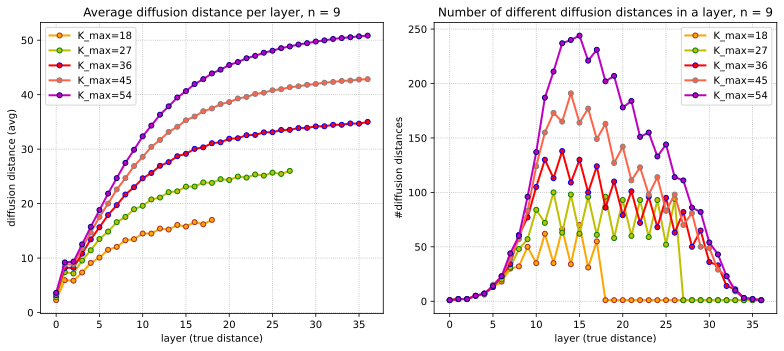

<Figure size 640x480 with 0 Axes>

In [7]:
plot_dd_combined(-3, range(5), save=True)

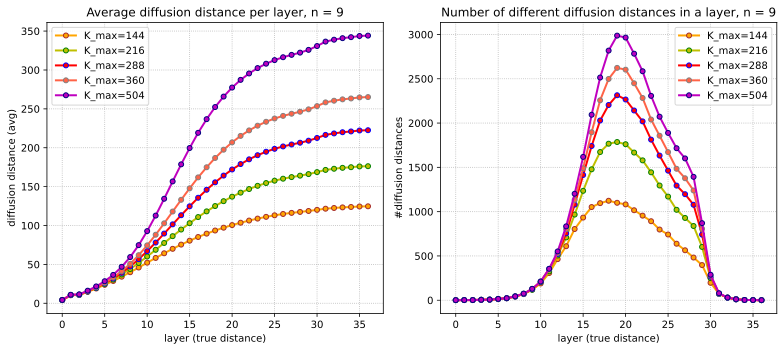

In [8]:
plot_dd_combined(-3, range(5, 10))

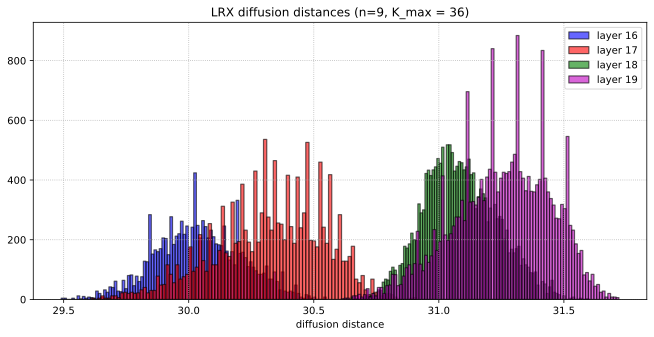

In [9]:
n = 9
plot_dd_hist(-3, 2, n*(n-1)//4 - 1)

Note the substantial intersections of histograms of diffusion distances of neighbor layers.

## DD for $n=10$

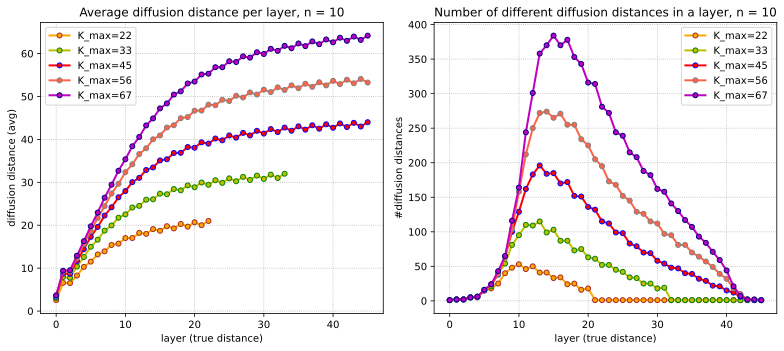

In [10]:
plot_dd_combined(-2, range(5))

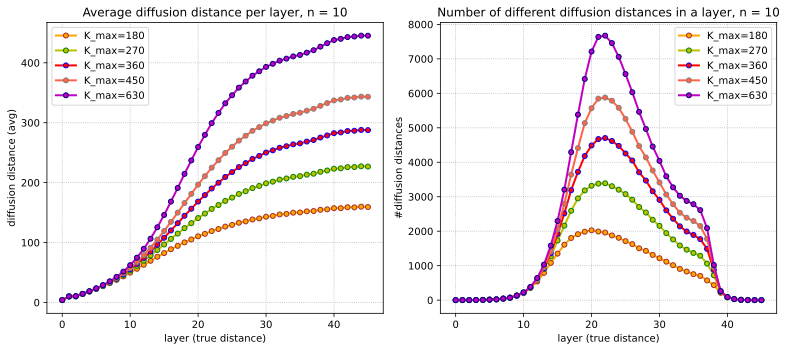

In [11]:
plot_dd_combined(-2, range(5, 10))

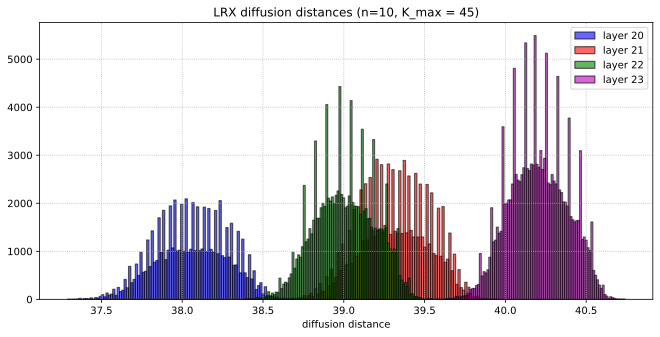

In [12]:
n = 10
plot_dd_hist(-2, 2, n*(n-1)//4 - 1, save=True)

For $n=10$ DD is not monotonic function of a layer.

## All in one plot

In [13]:
import plotly.graph_objects as go
import plotly.express as px

def plot_dd_means():
    fig = go.Figure()

    def counts(values):
        return [len(np.unique(values[j])) for j in range(len(values))]

    for i, n in enumerate(ns):
        for j, K_max in enumerate(K_max_lists[i]):
            fig.add_trace(
                go.Scatter(
                    x=np.arange(n*(n-1)//2 + 1),
                    y=dd_means_list[i][j],
                    name=f"K_max={K_max}",
                    visible=False,
                    mode="lines+markers",
                    line=dict(color=px.colors.qualitative.Dark24[j], width=3),
                    marker_line_width=2, 
                    marker_size=12 - n//2,
                    marker_line_color="white"            
                )
            )

    fig.update_layout(title={"text": f"Average diffusion distance per layer", "x": 0.5},
                      xaxis_title=r"layer (true distance)",
                      yaxis_title=r"diffusion distance (avg)",
                      margin=dict(t=50))

    visible_idx = len(ns) // 2
    for i in range(len(K_max_lists[visible_idx])):
        fig.data[i + visible_idx*len(ns)].visible = True

    steps = []
    for i in range(len(ns)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],  # layout attribute
            label=int(ns[i])
        )
        for j in range(len(K_max_lists[i])):
            step["args"][0]["visible"][j + i*len(K_max_lists[i])] = True 
        steps.append(step)

    sliders = [dict(
        active=visible_idx,
        pad={"t": 50},
        currentvalue={"prefix": "n="}, 
        steps=steps
    )]
        
    fig.update_layout(
        sliders=sliders,
    )
    fig.show(renderer='iframe')

In [14]:
plot_dd_means()

In [15]:
def plot_dd_counts():
    fig = go.Figure()

    def counts(values):
        return [len(np.unique(values[j])) for j in range(len(values))]

    for i, n in enumerate(ns):
        for j, K_max in enumerate(K_max_lists[i]):
            fig.add_trace(
                go.Scatter(
                    x=np.arange(n*(n-1)//2 + 1),
                    y=counts(dd_values_list[i][j]),
                    name=f"K_max={K_max}",
                    visible=False,
                    mode="lines+markers",
                    line=dict(color=px.colors.qualitative.Dark24[j], width=3),
                    marker_line_width=2, 
                    marker_size=12 - n//2,
                    marker_line_color="white" 
                )
            )

    fig.update_layout(title={"text": f"Number of different diffusion distances in a layer", "x": 0.5},
                      xaxis_title=r"layer (true distance)",
                      yaxis_title=r"# diffusion distance",
                      margin=dict(t=50))

    visible_idx = len(ns) // 2
    for i in range(len(K_max_lists[visible_idx])):
        fig.data[i + visible_idx*len(ns)].visible = True

    steps = []
    for i in range(len(ns)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],  # layout attribute
            label=int(ns[i])
        )
        for j in range(len(K_max_lists[i])):
            step["args"][0]["visible"][j + i*len(K_max_lists[i])] = True 
        steps.append(step)

    sliders = [dict(
        active=visible_idx,
        pad={"t": 50},
        currentvalue={"prefix": "n="}, 
        steps=steps
    )]
        
    fig.update_layout(
        sliders=sliders,
    )
    fig.show(renderer='iframe')

In [16]:
plot_dd_counts()

In [17]:
def plot_dd_histograms(K_max_idx, n_bins=30):
    fig = go.Figure()
    colors = ['blue', 'red', 'green', 'magenta']
    for i, n in enumerate(ns): 
        for j in range(-1, 3):
            layer_idx = n*(n-1)//4
            x_min = min(dd_values_list[i][K_max_idx][layer_idx + j])
            x_max = max(dd_values_list[i][K_max_idx][layer_idx + j])
            bin_edges = np.linspace(x_min, x_max, n_bins + 2*(n - ns[len(ns)//2]))
            fig.add_trace(
                go.Histogram(
                    x=dd_values_list[i][K_max_idx][layer_idx + j],
                    name=f"layer={layer_idx + j}",
                    visible=False,
                    marker_color=colors[j + 1],
                    opacity=0.5,
                    marker=dict(line=dict(color='black', width=1)),
                    xbins=dict(start=bin_edges[0], end=bin_edges[-1], size=np.diff(bin_edges).mean()),
                    autobinx=False 
                )
            )

    fig.update_layout(title={"text": f"Histogram of diffusion distances", "x": 0.5},
                      xaxis_title=r"diffusion distance",
                      margin=dict(t=50),
                      bargap=0)

    visible_idx = len(ns)//2
    for i in range(4):
        fig.data[i + visible_idx*4].visible = True

    steps = []
    for i in range(len(ns)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data), "bargap": 0}],  # layout attribute
            label=int(ns[i])
        )
        for j in range(4):
            step["args"][0]["visible"][j + i*4] = True 
        steps.append(step)

    sliders = [dict(
        active=visible_idx,
        pad={"t": 50},
        currentvalue={"prefix": "n="}, 
        steps=steps
    )]
        
    fig.update_layout(
        sliders=sliders,
        bargap=0,
    )
    fig.show(renderer='iframe')

In [18]:
plot_dd_histograms(2)